In [1]:
import numpy as np
import pandas as pd
import os
import pickle as pkl
import time
import matplotlib.pyplot as plt

In [4]:
path_data = os.path.join(os.getcwd(), "data")
path_scenario = os.path.join(os.getcwd(), "scenario")

In [5]:

path_cash = os.path.join(path_data, "C3M Historical Data.csv")
path_GVT_EU13 = os.path.join(path_data, "CSBGE3 Historical Data.csv")
path_EM = os.path.join(path_data, "EMKT Historical Data.csv")
path_GVT_EU57 = os.path.join(path_data, "X57E Historical Data.csv")
path_EQ_EU = os.path.join(path_data, "XESC Historical Data.csv")
path_EQ_US = os.path.join(path_data, "IUSEA Historical Data.csv")

In [6]:
def data_cleaning(dataset, nameETF):
    dataset["Date"] = pd.to_datetime(dataset.Date)
    # Sorting on Ascending Date
    dataset = dataset.sort_values("Date", ignore_index = True)
    # Correction for 0 Prices
    dataset.Price.replace(0, np.NaN, inplace = True)
    dataset.fillna(method="bfill", inplace = True)
    clean_dataset = pd.DataFrame()
    # Compute Exp return (Note: first Date useless)
    clean_dataset["Date"] = dataset.Date[:-1]
    clean_dataset[nameETF] = np.log(dataset.Price[1:].array/dataset.Price[:-1].array)
    return clean_dataset

raw_cash = pd.read_csv(path_cash)
cash = data_cleaning(raw_cash, "Cash")

raw_GVT_EU13 = pd.read_csv(path_GVT_EU13)
GVT_EU13 = data_cleaning(raw_GVT_EU13, "GVT_EU13")

raw_GVT_EU57 = pd.read_csv(path_GVT_EU57)
GVT_EU57 = data_cleaning(raw_GVT_EU57, "GVT_EU57")

raw_EM = pd.read_csv(path_EM)
EM = data_cleaning(raw_EM, "EM")

raw_EQ_EU = pd.read_csv(path_EQ_EU)
EQ_EU = data_cleaning(raw_EQ_EU, "EQ_EU")

raw_EQ_US = pd.read_csv(path_EQ_US)
EQ_US = data_cleaning(raw_EQ_US, "EQ_US")


In [7]:
ETF_HS = pd.DataFrame()
ETF_HS["Date"] = pd.date_range("1/1/2011", "31/12/2020")
ETF_HS = ETF_HS.merge(cash, how = "outer")
ETF_HS = ETF_HS.merge(GVT_EU13, how = "outer")
ETF_HS = ETF_HS.merge(GVT_EU57, how = "outer")
ETF_HS = ETF_HS.merge(EM, how = "outer")
ETF_HS = ETF_HS.merge(EQ_EU, how = "outer")
ETF_HS = ETF_HS.merge(EQ_US, how = "outer")
ETF_HS = ETF_HS.sort_values("Date", ignore_index = True)
ETF_HS.fillna(0, inplace = True)
ETF_HS.set_index("Date", inplace = True)
#ETF_HS.head()

In [8]:
# Resample ETF HS from daily to weekly
ETF_HS_W = ETF_HS.resample("W").sum()
# First entry useless (all 0 records)
ETF_HS_W = ETF_HS_W.iloc[ETF_HS_W.index>np.datetime64("2011-01-02")]
#ETF_HS_W.head()

In [9]:
P = list(ETF_HS.columns)
ETF_HS_W.describe().loc[["mean", "50%", "std"],P]*np.array([[52],[52],[np.sqrt(52)]])

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US
mean,-0.001423,0.009570,0.038129,0.031010,0.055719,0.107007
50%,-0.004301,0.004739,0.049907,0.124795,0.188141,0.167480
std,0.001700,0.013288,0.035018,0.207708,0.212798,0.167990


In [10]:
ETF_HS_W[P].corr()

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US
Cash,1.000000,0.385334,0.325676,0.045647,0.078905,0.038291
GVT_EU13,0.385334,1.000000,0.704937,0.126925,0.242598,0.130469
GVT_EU57,0.325676,0.704937,1.000000,0.152114,0.225065,0.093100
EM,0.045647,0.126925,0.152114,1.000000,0.732737,0.697830
EQ_EU,0.078905,0.242598,0.225065,0.732737,1.000000,0.783541
EQ_US,0.038291,0.130469,0.093100,0.697830,0.783541,1.000000


In [11]:
# mean - sigma definition for Geometric Brownian Motion
#mean_GBM = ETF_HS_W.describe().loc["50%"].values # 50% percentile may be more consistent than mean.
#mean_GBM = ETF_HS_W.describe().loc["mean"].values
mean_GBM = np.array([-0.001, 0.005, 0.015, 0.060, 0.070, 0.055 ])/52
sigma_GBM = ETF_HS_W.cov()

col_GBM = ["Date", "Simulation", "Cash", "GVT_EU13", "GVT_EU57", "EM", "EQ_EU", "EQ_US"]
ETF_GBM = pd.DataFrame(columns = col_GBM)
P = list(ETF_GBM.drop(["Date", "Simulation"], axis = 1).columns)
# Return scenarios number
n_sim = 1000

# projection_range: 50 years by month, starting from weekly exp-return sampling
projection_range = pd.date_range("1/1/2021", "31/12/2070", freq = "W")

for iteration in np.arange(n_sim):
    # sample exp-return
    simulated_return = np.random.multivariate_normal(mean = mean_GBM, cov = sigma_GBM, size = projection_range.shape)
    # Save sampled exp-return 
    iter_simul_W = pd.DataFrame(simulated_return, columns = ETF_GBM.drop(["Date","Simulation"], axis = 1).columns)
    iter_simul_W["Date"] = projection_range
    # Swap frequency from weekly to monthly
    iter_simul_M = iter_simul_W.set_index("Date").resample("M").sum()
    # Append last simulation to general scearios dataframe
    iter_simul_M.insert(2, "Simulation", pd.to_numeric(np.ones(iter_simul_M.shape[0])*iteration))
    ETF_GBM = ETF_GBM.append(iter_simul_M.reset_index(), ignore_index = True)

ETF_GBM[P] = ETF_GBM[P] - ETF_GBM[P].mean() + mean_GBM*52/12  
ETF_GBM["Simulation"] = ETF_GBM["Simulation"].astype("int32")

#ETF_GBM.head()

In [12]:
# Save scenarios dataframe
filename = os.path.join(path_scenario, "ETF_GBM.pkl")
fileopen = open(filename, "wb")
pkl.dump(ETF_GBM, fileopen)
fileopen.close()

In [13]:
tic = time.time()
# Scenario
N = ETF_GBM.Simulation.unique()
Scenario = {}
Simulation = ETF_GBM.Simulation
Date = ETF_GBM.Date
Scenario_df = ETF_GBM
for p in P:
    Scenario[p] = {} 
    for n in N:
        Scenario[p][n] = Scenario_df.loc[Simulation == n, p].array
toc = time.time()
print(f"Elapsed in {np.round(toc-tic,2)}s" )

Elapsed in 3.95s


In [14]:
# Save scenarios dataframe
filename = os.path.join(path_scenario, "Scenario.pkl")
fileopen = open(filename, "wb")
pkl.dump(Scenario, fileopen)
fileopen.close()

In [15]:
Scenario_corr = ETF_GBM[P].corr()
Scenario_mu = ETF_GBM[P].mean()
Scenario_sigma = ETF_GBM[P].cov()

In [16]:
Scenario_mu["Cash"]

-8.333333333333336e-05

In [17]:
user_portfolio = {"Cash":0, "GVT_EU13":0.25, "GVT_EU57":0.25, "EM":0.10, "EQ_EU":0.20, "EQ_US":0.20}
portfolio = pd.Series(user_portfolio.values(), index = user_portfolio.keys())
print(Scenario_sigma)
print(np.sqrt(np.sum((Scenario_sigma * portfolio).T.sum().T*portfolio)))

np.sqrt(np.dot(np.dot(portfolio,Scenario_sigma),portfolio))


                  Cash      GVT_EU13  GVT_EU57        EM     EQ_EU  \
Cash      2.418354e-07  7.277352e-07  0.000002  0.000001  0.000002   
GVT_EU13  7.277352e-07  1.476381e-05  0.000027  0.000030  0.000058   
GVT_EU57  1.624054e-06  2.743616e-05  0.000103  0.000094  0.000142   
EM        1.358790e-06  2.966139e-05  0.000094  0.003613  0.002713   
EQ_EU     2.392912e-06  5.763903e-05  0.000142  0.002713  0.003792   
EQ_US     8.924062e-07  2.458846e-05  0.000047  0.002038  0.002344   

                 EQ_US  
Cash      8.924062e-07  
GVT_EU13  2.458846e-05  
GVT_EU57  4.680417e-05  
EM        2.038155e-03  
EQ_EU     2.344174e-03  
EQ_US     2.358195e-03  
0.026528580466804536


0.026528580466804536

In [18]:
# Save scenarios propriety
filename = os.path.join(path_scenario, "Scenario_corr.pkl")
fileopen = open(filename, "wb")
pkl.dump(Scenario_corr, fileopen)
fileopen.close()

filename = os.path.join(path_scenario, "Scenario_mu.pkl")
fileopen = open(filename, "wb")
pkl.dump(Scenario_mu, fileopen)
fileopen.close()

filename = os.path.join(path_scenario, "Scenario_sigma.pkl")
fileopen = open(filename, "wb")
pkl.dump(Scenario_sigma, fileopen)
fileopen.close()

# Visual Analysis

In [19]:
scenarios = open( os.path.join(path_scenario, "ETF_GBM.pkl"), "rb")
GBM_analysis = pkl.load(scenarios)
scenarios.close()


In [20]:
P = list(GBM_analysis.drop(["Date", "Simulation"], axis = 1).columns)
GBM_analysis.describe().loc[["mean", "50%", "std"],P]*np.array([[12],[12],[np.sqrt(12)]])

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US
mean,-0.001000,0.005000,0.015000,0.060000,0.070000,0.055000
50%,-0.000993,0.005013,0.014981,0.059557,0.069743,0.054503
std,0.001704,0.013310,0.035104,0.208221,0.213303,0.168221


In [21]:
GBM_analysis[P].corr()

,Cash,GVT_EU13,GVT_EU57,EM,EQ_EU,EQ_US
Cash,1.000000,0.385136,0.325894,0.045968,0.079024,0.037369
GVT_EU13,0.385136,1.000000,0.704628,0.128428,0.243619,0.131778
GVT_EU57,0.325894,0.704628,1.000000,0.154823,0.227636,0.095111
EM,0.045968,0.128428,0.154823,1.000000,0.732951,0.698254
EQ_EU,0.079024,0.243619,0.227636,0.732951,1.000000,0.783959
EQ_US,0.037369,0.131778,0.095111,0.698254,0.783959,1.000000


In [22]:
N = GBM_analysis.Simulation.unique()
P = GBM_analysis.drop(["Date", "Simulation"], axis = 1).columns
Cum_return = pd.DataFrame(columns = GBM_analysis.columns)
Date = GBM_analysis.Date.unique()
for n in N:
    Cum_return_n = pd.DataFrame(np.cumsum(GBM_analysis.loc[GBM_analysis.Simulation==n, P].to_numpy(), axis=0),columns = P)
    Cum_return_n["Simulation"] = n
    Cum_return_n["Date"] = Date
    Cum_return = Cum_return.append(Cum_return_n)

perc_95 = Cum_return.groupby("Date").quantile(0.95)
perc_50 = Cum_return.groupby("Date").quantile(0.50)
perc_05 = Cum_return.groupby("Date").quantile(0.05)


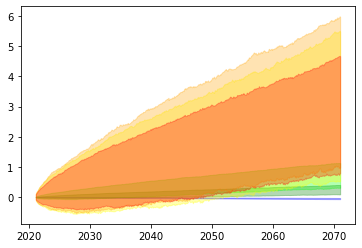

In [23]:
colormap = {P[0]:"blue", P[1]:"green", P[2]:"lime", P[3]:"yellow", P[4]:"orange", P[5]:"red"}
for p in P:
    plt.fill_between(perc_95.loc[perc_95.index < np.datetime64("2071-01-01")].index,perc_95.loc[perc_95.index < np.datetime64("2071-01-01"), p].to_numpy(),perc_05.loc[perc_05.index < np.datetime64("2071-01-01"), p].to_numpy(),alpha = 0.3, color = colormap[p])
plt.show()